In [2]:
# only needed in Jupyter Lab to see the images inline
%matplotlib widget

from plantcv import plantcv as pcv
from plantcv.parallel import WorkflowInputs
import matplotlib.pyplot as plt
import pandas as pd
import os
import json
import shutil

In [3]:
# Central Path Locations

image_path = "/Users/maxwellrosen/Library/CloudStorage/GoogleDrive-salkimager@gmail.com/My Drive/Desktop/Image_Holder/Temp_Staging_Area/Tray6.jpeg"
filename = image_path

# Change to Chamber folder: this is where the temporary data on pixel number in plants is saved
temp_desktop_image_results = "/Users/maxwellrosen/Storage/Salk_Plant_Imaging/eckerlabproj/On_Laptop/Desktop_Jupyter_Labs/Desktop_Trays/Temp_Results/temp_desktop_image_results.json"
# Change to location where data from this run is saved
analysis_results_csv_path = "/Users/maxwellrosen/Library/CloudStorage/GoogleDrive-salkimager@gmail.com/My Drive/Desktop/Final_Data/desktop_analysis_log.csv"
scale_values_path = "/Users/maxwellrosen/Storage/Salk_Plant_Imaging/eckerlabproj/On_Laptop/Desktop_Jupyter_Labs/Desktop_Trays/Pixels_to_mm/scale_values.json"
# Change to location where plant_names.csv is saved
plant_names_path = "/Users/maxwellrosen/Storage/Salk_Plant_Imaging/eckerlabproj/On_Laptop/Desktop_Jupyter_Labs/Desktop_Trays/plant_names_desktop_trays.csv"

In [4]:
time = "2025-10-31--2-20-00"

In [5]:
# Input/output options
args = WorkflowInputs(
    images=[image_path], # change to where the image will be
    names="image1",
    result=temp_desktop_image_results,
    outdir=".",
    writeimg=False,
    debug="plot"
    )

In [6]:
# Set debug to the global parameter 
pcv.params.debug = args.debug
# Change display settings
pcv.params.dpi = 100
# Increase text size and thickness to make labels clearer
# (size may need to be altered based on original image size)
pcv.params.text_size = 10
pcv.params.text_thickness = 20

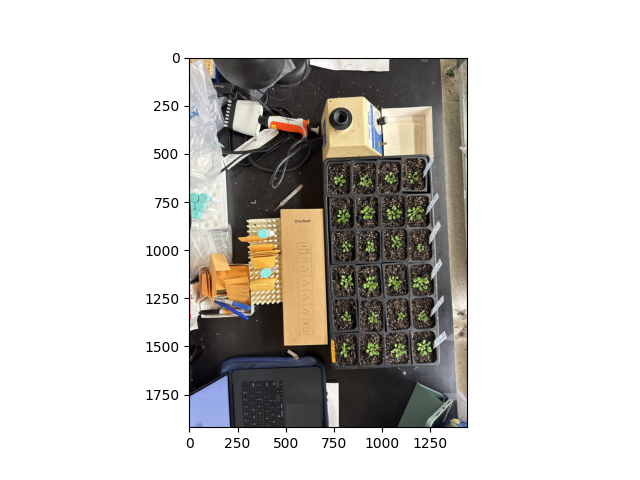

In [7]:
# Shows your image, defines it as "img"
img, path, filename = pcv.readimage(filename=args.image1)

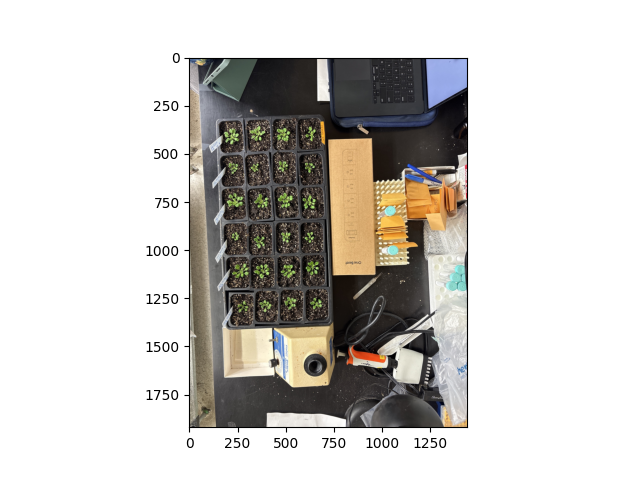

In [8]:
# Rotate image
rotated_img = pcv.transform.rotate(img, 180, True)

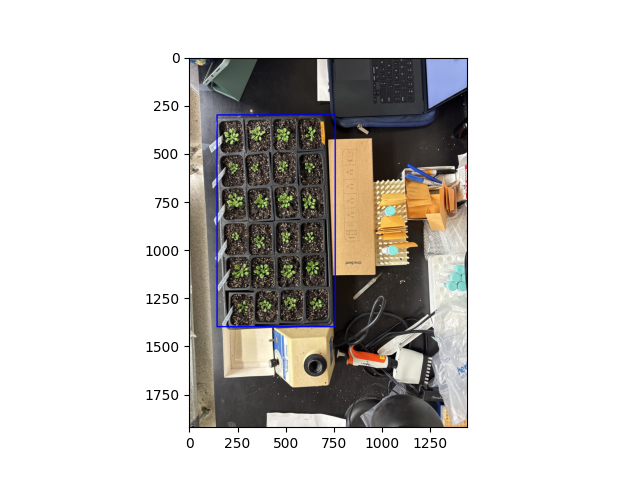

In [9]:
# Crops your image
crop_img = pcv.crop(img=rotated_img, x=145, y=300, w=752-139, h=1100)

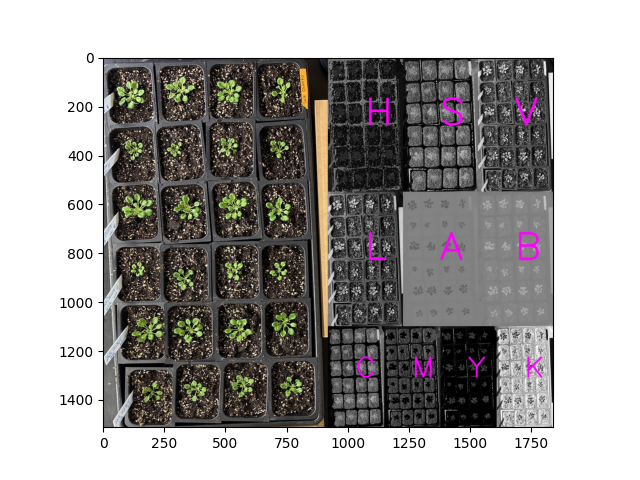

In [10]:
# Shows options for which channel to view the image through (ideally want the most contrast)
colorspace_img = pcv.visualize.colorspaces(rgb_img=crop_img)

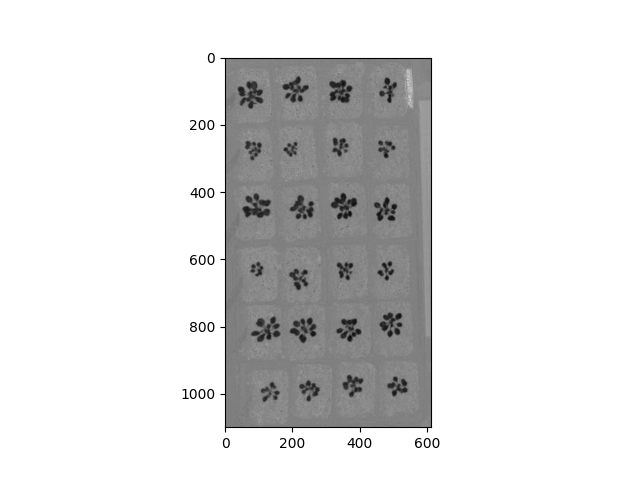

In [11]:
# Actually picks a channel with rgb2gray_"lab" and then the channel is the letter from "lab" that you look through
channeled_img = pcv.rgb2gray_lab(rgb_img=crop_img, channel='a')

In [12]:
# Visualization only, not needed for analysis
hist_figure1, hist_data1 = pcv.visualize.histogram(img = channeled_img, hist_data=True)

alt.Chart(...)

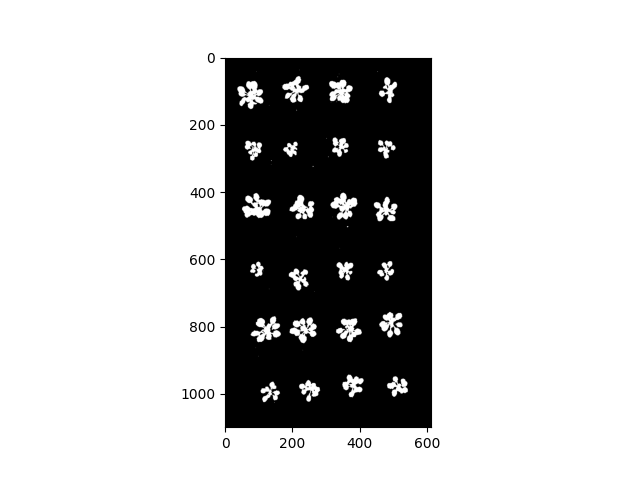

In [13]:
# Masks the image
thresh_mask = pcv.threshold.binary(gray_img=channeled_img, threshold=122, object_type='dark')

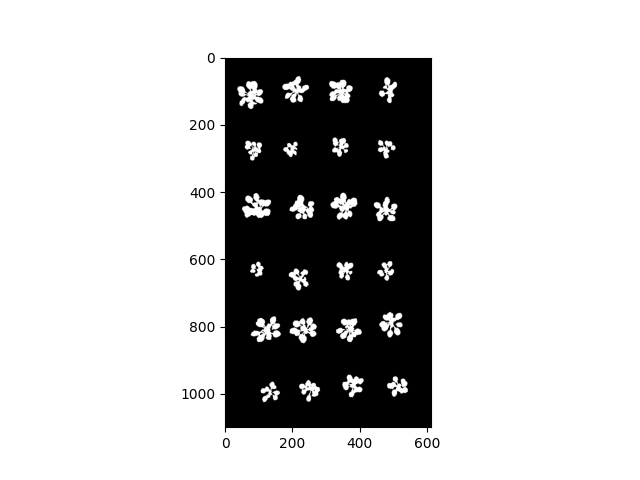

In [25]:
# Deletes groups of pixels less than the pixel size (weird dots around edges not plant is unmasked)
cleaned_mask = pcv.fill(bin_img=thresh_mask, size=100)

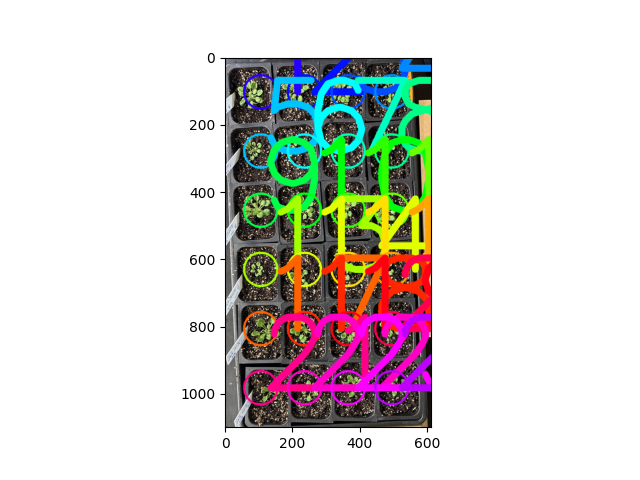

In [26]:
# Make new ROI's to select the different plants (use/change this for rows and columns of plants)
auto_rois = pcv.roi.auto_grid(mask=cleaned_mask, nrows=6, ncols=4, img=crop_img)

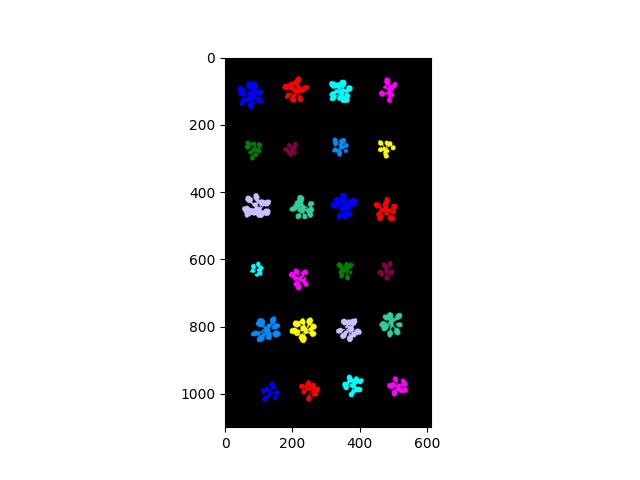

In [27]:
# Label and number objects in ROI; A good check to ensure different plants are different objects from being different colors
labeled_mask, num_plants = pcv.create_labels(mask=cleaned_mask, rois=auto_rois, roi_type='partial')

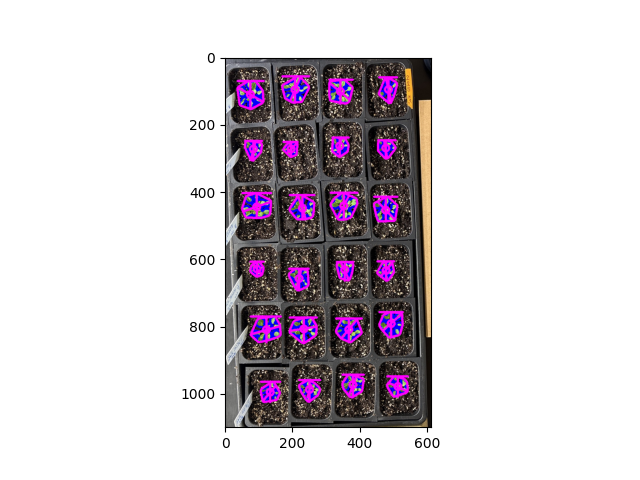

In [28]:
# Outputs analyzed image
shape_image = pcv.analyze.size(img=crop_img, labeled_mask=labeled_mask, n_labels=num_plants)

In [29]:
# Makes histogram of colors inside ROI
color_histogram = pcv.analyze.color(rgb_img=crop_img, labeled_mask=cleaned_mask, colorspaces='all', label="default")

alt.FacetChart(...)

In [30]:
# Saves results for the 1 image (running again overwites past results)
pcv.outputs.save_results(filename= args.result, outformat="json")

In [31]:
# Gets pixels to mm scalar s (mm per pixel, so: pixels * s^2 = mm^2)
with open(scale_values_path, "r") as f:
    scale_data = json.load(f)

mean_s = scale_data["mean_scale_mm2_per_pixel"]
std_s = scale_data["std_scale_mm2_per_pixel"]

In [32]:
# Create single-row DataFrame and adds to analysis log
df = pd.read_csv(plant_names_path)
for i in range(1,25): # starts at first number, ends right before second number
    n = i + 120
    pixels_value = pcv.outputs.observations[f"default_{i}"]["area"]["value"]
    plant_number = f"plant{n}"
    plant_ID = df.loc[df["old_plant_number"] == plant_number, "new_name"].values[0]
    stress = df.loc[df["old_plant_number"] == plant_number, "stress"].values[0]
    new_data = pd.DataFrame([{
        "time": time,
        "plant_number": plant_number, 
        "plant_name": plant_ID,
        "stress_level (%)": stress,
        "Area (mm^2)": pixels_value * mean_s,
        # "Uncertainty (mm^2)": pixels_value * 2 * mean_s * std_s
    }])
    # If analysis_log.csv doesn't exist, creates it with a header:
    if not os.path.isfile(analysis_results_csv_path):
        new_data.to_csv(analysis_results_csv_path, index=False)
    else:
        # Append without writing header again
        new_data.to_csv(analysis_results_csv_path, mode='a', header=False, index=False)

In [22]:
# Full paths
src_path = '/Users/maxwellrosen/Library/CloudStorage/GoogleDrive-salkimager@gmail.com/My Drive/Desktop/Image_Holder/Temp_Staging_Area/Tray6.jpeg'
dst_path = '/Users/maxwellrosen/Library/CloudStorage/GoogleDrive-salkimager@gmail.com/My Drive/Desktop/Image_Holder/Longterm_Storage/Tray6.jpeg'

# Moves file to long-term folder
shutil.move(src_path, dst_path)

'/Users/maxwellrosen/Library/CloudStorage/GoogleDrive-salkimager@gmail.com/My Drive/Desktop/Image_Holder/Longterm_Storage/Tray6.jpeg'

In [23]:
plt.close('all')